In [1]:
%%capture
!pip install llama-index
!pip install llama-index-embeddings-huggingface

In [2]:
import json
import os
import matplotlib.pyplot as plt
import glob
import requests
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import tqdm

import nest_asyncio
nest_asyncio.apply()

from llama_index.core.evaluation import generate_question_context_pairs
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core.evaluation import generate_question_context_pairs
from llama_index.core.evaluation import RetrieverEvaluator
from llama_index.llms.openai import OpenAI

import os
import pandas as pd

In [3]:
from typing import List

In [4]:
open_api_key = ""
os.environ['OPENAI_API_KEY'] = open_api_key

### Load data

In [5]:
data = json.load(open('test_set.json'))
labels = json.load(open('test_ground_truth.json'))
len(data), len(labels)

(500, 500)

In [6]:
list(labels.keys())[:5]

['12377809', '26163474', '19100463', '18537964', '12913878']

In [7]:
list(data.keys())[:5]

['12377809', '26163474', '19100463', '18537964', '12913878']

In [8]:
from llama_index.core import Document

documents = []
for i, q in tqdm.tqdm(data.items()):
    context = str(q['CONTEXTS'])
    documents.append(Document(text=context))

print(len(documents))

100%|██████████| 500/500 [00:00<00:00, 14019.52it/s]

500


In [9]:
import collections
data_dict = collections.defaultdict()

for i, q in tqdm.tqdm(data.items()):
    question = str(q['QUESTION'])
    context = str(q['CONTEXTS'])
    data_dict[question] = context

100%|██████████| 500/500 [00:00<00:00, 42277.03it/s]


## Build DB

In [10]:
llm = OpenAI(model="gpt4-0125-preview") # OR gpt4-0125-preview, gpt-4-turbo-2024-04-09

In [11]:
from llama_index.core.embeddings import resolve_embed_model

embed_model = resolve_embed_model("local:BAAI/bge-small-en")

vector_index = VectorStoreIndex.from_documents(documents, embed_model=embed_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Running example

In [12]:
query_engine = vector_index.as_query_engine()
response_vector = query_engine.query("Is there a connection between sublingual varices and hypertension?")
response_vector.response

'Yes, there is a connection between sublingual varices and hypertension.'

## Qualitative performance

In [28]:
# Retrieving Error cases, where the context was not in the top-1
retriever = vector_index.as_retriever(similarity_top_k=3)

i = 0
for question, true_context in data_dict.items():
  i += 1

  retrieved_items = retriever.retrieve(question)
  if data_dict[question] not in  retrieved_items[0].text:
    for rank, el in enumerate(retrieved_items, start=1):
      print(question, el.text)

The Main Gate Syndrome: a new format in mass-casualty victim "surge" management? ["The incidence of large-scale urban attacks on civilian populations has significantly increased across the globe over the past decade. These incidents often result in Hospital Multiple Casualty Incidents (HMCI), which are very challenging to hospital teams. 15 years ago the Emergency and Disaster Medicine Division in the Israeli Ministry of Health defined a key of 20 percent of each hospital's bed capacity as its readiness for multiple casualties. Half of those casualties are expected to require immediate medical treatment. This study was performed to evaluate the efficacy of the current readiness guidelines based on the epidemiology of encountered HMCIs.", 'A retrospective study of HMCIs was recorded in the Israeli Defense Force (IDF) home front command and the Israeli National Trauma Registry (ITR) between November 2000 and June 2003. An HMCI is defined by the Emergency and Disaster Medicine Division in

In [32]:
data_dict['Do overweight children necessarily make overweight adults?']

"['To compare growth curves of body mass index from children to adolescents, and then to young adults, in Japanese girls and women in birth cohorts born from 1930 to 1999.', 'Retrospective repeated cross sectional annual nationwide surveys (national nutrition survey, Japan) carried out from 1948 to 2005.', 'Japan.', '76,635 females from 1 to 25 years of age.', 'Body mass index.', 'Generally, body mass index decreased in preschool children (2-5 years), increased in children (6-12 years) and adolescents (13-18 years), and slightly decreased in young adults (19-25 years) in these Japanese females. However, the curves differed among birth cohorts. More recent cohorts were more overweight as children but thinner as young women. The increments in body mass index in early childhood were larger in more recent cohorts than in older cohorts. However, the increments in body mass index in adolescents were smaller and the decrease in body mass index in young adults started earlier, with lower peak 

## Evaluation of Retrieval

In [62]:
def evaluate_metrics(d, vector_index, top_k):
    hits = 0
    reciprocal_ranks = []

    retriever = vector_index.as_retriever(similarity_top_k=top_k)

    for question, true_context in d.items():
        retrieved_items = retriever.retrieve(question)

        hit = False
        for rank, el in enumerate(retrieved_items, start=1):
            if true_context in el.text :
                if not hit:
                    hits += 1
                    reciprocal_ranks.append(1 / rank)
                hit = True

    hit_rate = hits / len(d)
    mrr = sum(reciprocal_ranks) / len(d) if reciprocal_ranks else 0
    return hit_rate, mrr

# Evaluate metrics for top k
top_k_values = [1, 2, 3]
results = {}
for k in top_k_values:
    hit_rate, mrr = evaluate_metrics(data_dict, vector_index, k)
    results[k] = {'Hit Rate': hit_rate, 'MRR': mrr}

for k, metrics in results.items():
    print(f"Top {k}: Hit Rate = {metrics['Hit Rate']:.2f}, MRR = {metrics['MRR']:.4f}")

Top 1: Hit Rate = 0.98, MRR = 0.9840
Top 2: Hit Rate = 0.99, MRR = 0.9870
Top 3: Hit Rate = 0.99, MRR = 0.9870


## Evaluation on QA

In [12]:
predictions, gt = {}, {}

class_dict = { 'no': 0, 'yes': 1, 'maybe': 2, 'none':3}
query_engine = vector_index.as_query_engine()

for i, q in tqdm.tqdm(data.items()):
    question = str(q['QUESTION'])
    text_prompt = "Answer question {}. Answer can only be one word and it should be either 'yes', 'no', or 'maybe'.".format(
        question)

    response_vector = query_engine.query(text_prompt)
    resp = response_vector.response

    r = 'none'
    if 'no' in resp.lower():
        r = 'no'
    elif 'yes' in resp.lower():
        r = 'yes'
    elif 'maybe' in resp.lower() or 'perhaps' in resp.lower():
        r = 'maybe'

    predictions.update({i: class_dict[r]})
    gt.update({i: class_dict[labels[i]]})

100%|██████████| 500/500 [05:29<00:00,  1.52it/s]


In [13]:
accuracy_score(list(gt.values()), list(predictions.values() ))

0.69

In [14]:
f1_score(list(gt.values()), list(predictions.values()), average='macro')

0.5075679399087727

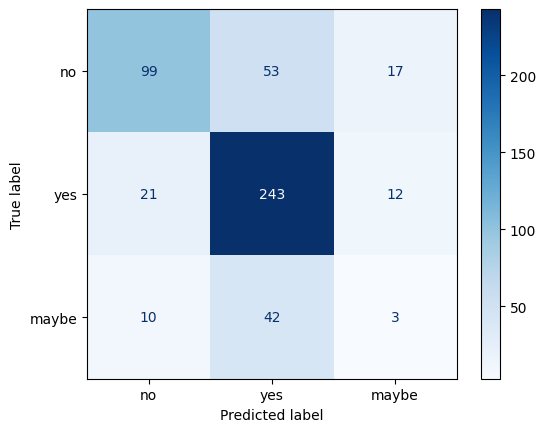

In [43]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(list(gt.values()), list(predictions.values()), labels=[0,1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes', 'maybe'])
disp.plot(cmap=plt.cm.Blues,)
plt.show()

## Examples

In [36]:
c = 0
for i, q in tqdm.tqdm(data.items()):
  c += 1
  if c >420:
    print(q['QUESTION'], labels[i])
  if c >440:
    break

 88%|████████▊ | 440/500 [00:00<00:00, 362501.23it/s]

Surgical management of the atherosclerotic ascending aorta: is endoaortic balloon occlusion safe? no
Is there a relationship between serum paraoxonase level and epicardial fat tissue thickness? no
Do antibiotics decrease post-tonsillectomy morbidity? no
Should prostate specific antigen be adjusted for body mass index? no
Is it necessary to insert a nasobiliary drainage tube routinely after endoscopic clearance of the common bile duct in patients with choledocholithiasis-induced cholangitis? no
Have antiepileptic drug prescription claims changed following the FDA suicidality warning? no
Are high flow nasal cannulae noisier than bubble CPAP for preterm infants? no
Are the arginine vasopressin V1a receptor microsatellites related to hypersexuality in children with a prepubertal and early adolescent bipolar disorder phenotype? no
Are variations in the use of carotid endarterectomy explained by population Need? no
Do supervised colorectal trainees differ from consultants in terms of quality

In [38]:
query_engine = vector_index.as_query_engine()
response_vector = query_engine.query(" Answer question: Xanthogranulomatous cholecystitis: a premalignant condition?. Answer can only be one word and it should be either 'yes', 'no', or 'maybe'. ")
response_vector.response

'Maybe'